In [1]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F

from copy import deepcopy
from typing import List, Dict
from collections import deque, namedtuple

import random
import math

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Resolvendo o ambiente Lunar Lander com Deep Q-Learning

O [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) possui um espaço de estados contínuo o que torna muito mais difícil a sua solução por métodos tabulares. Sendo assim, esse ambiente é ideal para a aplicação do Deep Q-Learning e suas variações. O objetivo principal do Lunar Lander é usar três motorers de uma nave espacial para pousá-la o mais perto possível de uma plataforma de pouso. Um episódio é definido como vitória/derrota com base na pontuação final obtida.

<img src="media/lunar_lander.gif" width="200">

Abaixo seguem algumas informações importantes para a modelagem do ambiente como um Processo de Decisão de Markov (MDP):

### Espaço de ações

O espaço de ações é discreto e contém os inteiros do intervalo {0, 3}. Uma ação deve indicar a direção de um movimento:
* 0: Não fazer nada
* 1: Ativar motor esquerdo
* 2: Ativar motor principal
* 3: Ativar motor direito

### Espaço de estados

O vetor de estado possui oito elementos: coordenadas x & y, velocidades x & y, ângulo, velocidade de rotação e duas variáveis booleanas que indicam se as pernas da nave estão ou não tocando o chão. 

### Recompensas

A cada passo temporal, a recompensa:

* é aumentada/diminuída se a nave se aproximar/distanciar da plataforma de pouso.
* é aumentada/diminuída se a nave se movimentar mais devagar/rápido.
* é diminuída quanto mais a nave estiver inclinada.
* é aumentada em 10 pontos para cada perna da nave que estiver tocando o chão.
* é diminuída em 0.03 pontos para cada frame em que um motor lateral estiver ativo.
* é diminuída em 0.3 pontos para cada frame em que o motor principal estiver ativo.

No final do episódio, uma recompensa adicional de -100 ou +100 é atribuída caso a a nave colida ou pouse com segurança.

Caso a pontuação final seja maior que 200, o episódio é considerado como solução.


## Criando o modelo

No Deep Q-Learning, os Q-valores de cada ação associados a um estado são calculados através de uma rede neural. Ou seja, a rede neural recebe como entrada um vetor de estados e deve retornar o vetor de Q-valores onde cada elemento representa o Q-valor de uma ação. Um Q-valor pode ser interpretado como "a recompensa acumulada total esperada por executar a ação A no estado S e depois seguir a mesma política até o final do episódio".

O vetor de estados do Lunar Lander já vem em um formato adequado para a entrada de uma rede neural então não é necvessário formatá-lo, apenas transformá-lo em um tensor do PyTorch.

In [2]:
class Qnet(nn.Module):
    def __init__(self, layer_sizes: List[int] = [64, 64], n_actions=4):
        super().__init__()

        # construindo a rede neural
        layers = []
        input_size = 8
        for n_neurons in layer_sizes:
            layers.append(nn.Linear(input_size, n_neurons))
            layers.append(nn.ReLU())
            input_size = n_neurons
        layers.append(nn.Linear(input_size, n_actions))
        self.nn = nn.Sequential(*layers)

    def forward(self, x):
        x = self.nn(x)
        return x

## Replay buffer

Replay buffers são utilizados para armazenar transições de estado observadas durante o processo de treinamento. A rede neural utiliza batches de transições (não necessariamente sequenciais!) para calcular a loss e atualizar seus pesos. O uso de replay buffers torna o processo de aprendizado mais eficiente pois permite que a rede aprenda a partir de uma transição várias vezes além de ajudar a aumentar a estabilidade do treinamento da rede neural.


In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'terminated'))

class ReplayBuffer:
    def __init__(self, capacity=1024):
        self.buffer = deque([], maxlen=capacity)
    
    def push(self, *args):
        """ Save a transition into the buffer."""
        self.buffer.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)


## Amostrando ações com a política $\epsilon$-greedy

No final do treinamento, espera-se que a melhor ação para cada estado seja aquela cujo Q-Valor é o maior. No entanto, para que o Q-Learning convirja adequadamente, é necessário que no início do treinamento o agente "explore" bem o ambiente. Isto é, que o agente visite um grande número de estados mesmo que não sejam necessariamente ótimos. Uma técnica amplamente utilizada para essa finalidade é a política $\epsilon$-greedy. Ela consiste em forçar o agente a escolher ações aleatoriamente com uma frequência que diminui conforme o treinamento avança.

In [4]:
@torch.no_grad()
def get_action(model, state, epsilon, n_actions=4):
    if torch.rand(1) < epsilon:
        return torch.randint(n_actions, (1,)).item()
    qvals = model(torch.tensor(state, dtype=torch.float32).float().to(DEVICE))
    return torch.argmax(qvals).item()

## Treinamento da rede neural 

A cada passo do treinamento, o agente executará uma ação e utilizará a informação retornada pelo ambiente para calcular uma loss e atualizar seus pesos de forma a minimizá-la. A loss que será utilizada é o erro quadrático médio entre o Q-valor escolhido e o maior Q-valor do próximo estado calculado utilizando a rede com os pesos anteriores à ultima atualização:

$$L_i(\theta_i)=\mathbb{E}[(y_i - Q(s,a;\theta_i))^2]$$
$$y_i=\mathbb{E}[R(s')+\gamma\max_A Q(s',A;\theta_{i-1})]$$

Note que, portanto, serão necessárias duas redes neurais com a mesma arquitetura, mas uma terá os pesos deefasados em uma iteração com relação à outra.

In [5]:
def update_q_net(model: Qnet, 
                 model_target: Qnet,
                 optimizer: torch.optim.Optimizer, 
                 batch_of_transitions: List[Transition],
                 gamma):
    
    # Convert a list of Transitions into a Transition of lists
    # Check: https://stackoverflow.com/questions/19339/transpose-unzip-function-inverse-of-zip/19343#19343
    batch = Transition(*zip(*batch_of_transitions))
    
    # transformando o batch de estados em um tensor
    states = torch.cat(batch.state)
    actions = torch.cat(batch.action)
    rewards = torch.cat(batch.reward)
    next_states = torch.cat(batch.next_state)
    terminated = torch.cat(batch.terminated)
    
    predictions = model(states).gather(1, actions.unsqueeze(1)).squeeze() # seleciona o qval da acao tomada

    # se o estado é terminal, o valor é a recompensa
    with torch.no_grad():
        targets = rewards + gamma * model_target(next_states).max(-1).values * (1 - terminated.int()) # else rewards + gamma * max_a Q(s', a)
    
    loss = F.mse_loss(predictions, targets)

    # atualizando os pesos da rede
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return model

## Loop de treinamento

No loop de treinamento, juntaremos todas as funções desenvolvidas até o momento. A ideia principal é definir um número máximo de episódios (estágio inicial até o estágio final) para que o agente colete experiências do ambiente e otimize sua tabela de QValores.

In [6]:
def evaluate(metrics: Dict, show_result=False):
    rewards = torch.tensor(metrics['episode_rewards'])
    plt.figure(1)
    plt.clf
    plt.title('Total reward of each episode')
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.grid()
    plt.plot(rewards)

    # Take 100 episode averages and plot them too
    if metrics['avg_reward'] is not None: 
        x = range(49, 49 + len(metrics['avg_reward']))
        plt.plot(x, metrics['avg_reward'].numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated

    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())


In [7]:
def train(
        env: gym.Env, 
        model: Qnet,
        total_steps=450_000,
        replay_buffer_size=2 ** 20, # tamanho do replay buffer
        batch_size=128, # tamanho do batch
        gamma=0.99,
        learning_rate=5e-4,
        learning_freq=1,
        target_update_freq=100,
        tau=1.0,
        epsilon_0 = 1, # probabilidade inicial de escolher uma ação aleatória
        epsilon_f=0.05, # probabilidade final de escolher uma ação aleatória (após o decaimento)
        epsilon_decay = 100_000, # step in which epsilon will be approximately epsilon_f + 0.36 * (epsilon_0 - epsilon_f)
        verbose=False):
    
    model_target = deepcopy(model)

    def eps_scheduler(step):
        return epsilon_f + (epsilon_0 - epsilon_f) * math.exp(-1. * step / epsilon_decay)

    replay_buffer = ReplayBuffer(replay_buffer_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    state, _ = env.reset()
    total_reward = 0
    metrics = {
        'episode_rewards': [],
        'avg_reward': None,
    }
    episode_step = 0
    truncated = False

    for global_step in range(total_steps):
        epsilon = eps_scheduler(global_step)

        # observe
        action = get_action(model, state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        replay_buffer.push(
            torch.tensor([state], dtype=torch.float32).to(DEVICE), 
            torch.tensor([action], dtype=torch.int64).to(DEVICE), 
            torch.tensor([reward], dtype=torch.float32).to(DEVICE), 
            torch.tensor([next_state], dtype=torch.float32).to(DEVICE), 
            torch.tensor([terminated], dtype=torch.float32).to(DEVICE) 
            )
        state = next_state
        total_reward += reward
        episode_step += 1
        done = terminated or truncated

        # update
        if global_step > batch_size and global_step % learning_freq == 0:
            batch = replay_buffer.sample(batch_size)
            model = update_q_net(model, model_target, optimizer, batch, gamma)

        # update target network
        if global_step % target_update_freq == 0:
            model_target.load_state_dict(model.state_dict())

            for target_net_param, q_net_param in zip(model_target.parameters(), model.parameters()):
                    target_net_param.data.copy_(
                        tau * q_net_param.data + (1.0 - tau) * target_net_param.data
                    )

        # evaluating
        if done:
            metrics['episode_rewards'].append(total_reward)
            if len(metrics['episode_rewards']) > 50:
                metrics['avg_reward'] = torch.tensor(metrics['episode_rewards']).float().unfold(0, 50, 1).mean(1)
                print(f'avg reward: {metrics["avg_reward"][-1]}')
            print(f'current step: {global_step}, epsilon: {epsilon:.2f}')
            # if global_step % 10_000 == 0:
            #     evaluate(metrics)
            evaluate(metrics)
            total_reward = 0
            state, _ = env.reset()
            episode_step = 0
            truncated = False

    evaluate(metrics, show_result=True)
    return model

## Treinando

Está tudo configurado, portanto agora podemos rodar o algoritmo!

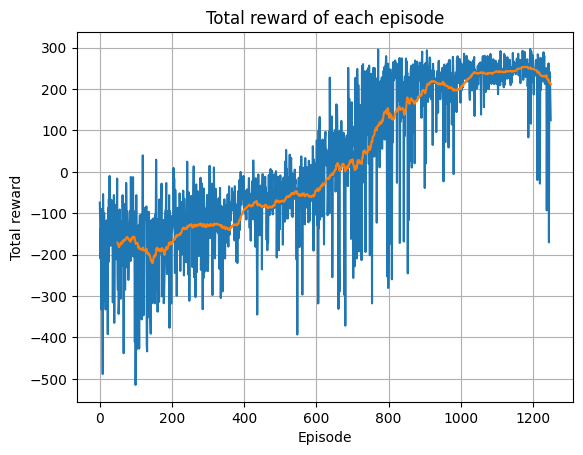

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
lunar_lander = gym.make('LunarLander-v2')
q_net = Qnet().to(DEVICE)
trained_q_net = train(lunar_lander, q_net, verbose=True)

30m

## Testando o agente

A função abaixo rodará um episódio com o agente já treinado.

In [18]:
def test(env: gym.Env, 
          q_net,
          n_episodes=1,
          verbose=False
          ):
    
    total_rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = get_action(q_net, state, 0)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            done = terminated or truncated

        if verbose:
            print(f"Episode {episode} - Total reward: {total_reward}")
            
        total_rewards.append(total_reward)

    env.close()
    total_reward = torch.tensor(total_rewards, dtype=torch.float32)
    return torch.mean(total_reward)

test(gym.make('LunarLander-v2', render_mode="human"), trained_q_net)

tensor(258.7786)

## Exercício - ambientes não-determinísticos

O Lunar Lander, assim como o Cliff Walking, também possui uma versão com vento aleatório que faz com que o ambiente se torne não determinístico. Tente encontrar uma taxa de aprendizado que permita solucionar essa versão do ambiente! Ela é maior ou menor que a taxa utilizada anteriormente? O efeito de um ambiente não determinístico sobre a taxa de aprendizado é análogo ao observado no algoritmo tabular?

avg reward: -259.6629943847656
current step: 7496, epsilon: 0.93


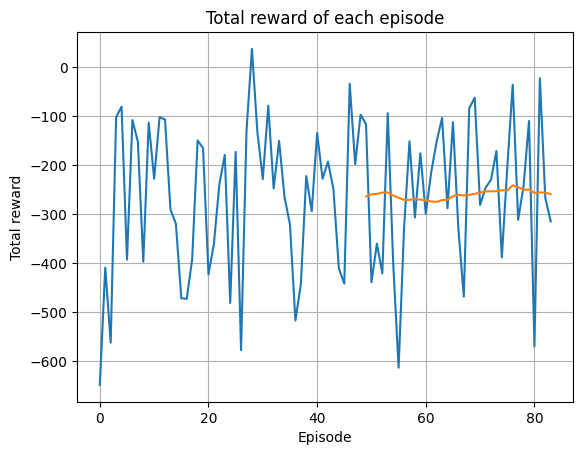

<Figure size 640x480 with 0 Axes>

In [19]:
nd_lunar_lander = gym.make('LunarLander-v2', enable_wind=True, render_mode="human")
nd_q_net = Qnet()
# trained_nd_q_net = train(nd_lunar_lander, nd_q_net, total_steps=450_000, epsilon_decay=100_000, learning_rate=5e-4, replay_buffer_size=2 ** 20, batch_size=128, verbose=True)